In [ ]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/andrewmvd/animal-faces")

# Productin ready Image Classification

In [1]:
!pip install torchmetrics --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 54.0 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.transforms.functional import InterpolationMode #for new torchvision
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from PIL import Image
import pandas as pd
import numpy as np
import os
import time
import json
import torchmetrics
import matplotlib.pyplot as plt
import copy

## configuration

In [3]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/andrewmvd/animal-faces")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: prajwalhiremath
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/andrewmvd/animal-faces


100%|██████████| 696M/696M [00:00<00:00, 1.67GB/s]


In [66]:
DATA_DIR = "/content/animal-faces/afhq" #Base directory of the dataset
MODEL_SAVE_PATH = "best_animal_classifier.pth"
LABEL_MAP_PATH = "label_mapping.json"
IMAGE_SIZE = 128
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 1e-4
RANDOM_STATE = 42
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_WORKERS = 2 #For DataLoader, adjust based on the system

print(f"Using Device : {DEVICE}")

Using Device : cuda


## 1. DATA Loading and Preparation

In [67]:
def load_image_paths(data_dir):
  image_paths = []
  labels = []
  class_names = set()

  for split in os.listdir(data_dir):
    split_path = os.path.join(data_dir, split)
    if not os.path.isdir(split_path):
      continue
    for label in os.listdir(split_path):
      label_path = os.path.join(split_path, label)
      if not os.path.isdir(label_path):
        continue
      class_names.add(label)
      for image_file in os.listdir(label_path):
        if image_file.lower().endswith(('.png','.jpg','.jpeg')):
          image_paths.append(os.path.join(label_path, image_file))
          labels.append(label)
  if not image_paths:
    raise ValueError(f"No images found in {data_dir}. Check the directory")
  df = pd.DataFrame({"image_path":image_paths, "label":labels})
  sorted_classes = sorted(list(class_names))
  label_map = {name: idx for idx, name in enumerate(sorted_classes)}
  df['label_idx'] = df['label'].map(label_map)

  print(f"Found {len(df)} images belonging to {len(label_map)} classes")
  print(f"Class distribution:\n{df['label'].value_counts()}")
  return df, label_map

### Load data and create label map

In [68]:
try:
  data_df, label_map = load_image_paths(DATA_DIR)
  num_classes = len(label_map)

  #save label mapping for inference later
  with open(LABEL_MAP_PATH, 'w') as f:
    json.dump(label_map, f)
  print(f"Label mapping saved to : {LABEL_MAP_PATH}")
  print(f"Label Map : {label_map}")

  #split data (using sklearn for startification)
  #train, val, test -> 70%, 15%, 15%
  train_df, temp_df = train_test_split(
      data_df,
      test_size=0.3,
      random_state=RANDOM_STATE,
      stratify=data_df['label_idx']
  )
  val_df, test_df = train_test_split(
      temp_df,
      test_size=0.5,
      random_state=RANDOM_STATE,
      stratify=temp_df['label_idx']
  )
  print(f"\nDataset split:\n")
  print(f"Train: {len(train_df)} samples")
  print(f"Validation: {len(val_df)} samples")
  print(f"Test: {len(test_df)} samples")
except ValueError as e:
  print(f"Error loading data: {e}")
  exit()
except Exception as e:
  print(f"Error during data loading : {e}")
  exit()

Found 16130 images belonging to 3 classes
Class distribution:
label
cat     5653
dog     5239
wild    5238
Name: count, dtype: int64
Label mapping saved to : label_mapping.json
Label Map : {'cat': 0, 'dog': 1, 'wild': 2}

Dataset split:

Train: 11291 samples
Validation: 2419 samples
Test: 2420 samples


## 2. Define Transforms

Different transforms for training (agumentation) and val/testing

In [69]:
train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE), interpolation=InterpolationMode.BILINEAR),
    transforms.RandomHorizontalFlip(p=0.5), #simple augemtation
    transforms.RandomRotation(10),#simple augemtation
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),#More agumentation
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])#imagenet stats often work well
])
val_test_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE), interpolation=InterpolationMode.BILINEAR),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

## 3. Custom Dataset

In [70]:
class AnimalDataset(Dataset):
  def __init__(self, dataframe, transform=None):
    self.dataframe = dataframe
    self.transform = transform
    #store the paths and labels directly
    self.image_paths = dataframe['image_path'].tolist()
    self.labels = dataframe['label_idx'].tolist()

  def __len__(self):
    return len(self.dataframe)

  def __getitem__(self, idx):
    img_path = self.image_paths[idx]
    label = self.labels[idx]

    try:
      #open image and ensure it's RGB
      image = Image.open(img_path).convert('RGB')
    except FileNotFoundError:
      print(f"Image not found {img_path}. Skipping")
      return torch.zeros(3, IMAGE_SIZE, IMAGE_SIZE), -1
    except Exception as e:
      print(f"Warning: Error opening image {img_path}:{e}, skipping")
      return torch.zeros(3, IMAGE_SIZE, IMAGE_SIZE), -1

    if self.transform:
      image = self.transform(image)

    return image, torch.tensor(label, dtype = torch.long) #CrossEntropyLoss expects long tensors for labels



## 4. Create Datasets and DataLoaders

In [71]:
train_dataset = AnimalDataset(train_df, transform=train_transform)
val_dataset = AnimalDataset(val_df, transform=val_test_transform)
test_dataset = AnimalDataset(test_df, transform=val_test_transform)

In [72]:
#Use Persistent_workers=True if available for faster startup after first epoch
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True if DEVICE == "cuda" else False,
    persistent_workers=True if NUM_WORKERS > 0 else False,
)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False, #No need
    num_workers=NUM_WORKERS,
    pin_memory= True if DEVICE == "cuda" else False,
    persistent_workers=True if NUM_WORKERS > 0 else False,
)
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True if DEVICE=="cuda" else False,
    persistent_workers=True if NUM_WORKERS > 0 else False,
)

print("\nDataLoaders Created.\n")


DataLoaders Created.



##  5. Define the Model

In [73]:
class Net(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # Conv Block 1
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32) # Added BatchNorm
        # Conv Block 2
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64) # Added BatchNorm
        # Conv Block 3
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128) # Added BatchNorm

        self.pooling = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        # Calculate the flattened size dynamically (robust to IMAGE_SIZE changes)
        # We need to do a dummy forward pass to determine the size
        # This assumes IMAGE_SIZE is divisible by 2 three times (due to 3 pooling layers)
        if IMAGE_SIZE % 8 != 0:
             print("Warning: Image size might not be perfectly divisible by pooling layers.")

        # Determine flattened size after conv/pool blocks
        # Dummy input: batch_size=1, channels=3, height=IMAGE_SIZE, width=IMAGE_SIZE
        with torch.no_grad():
             dummy_input = torch.zeros(1, 3, IMAGE_SIZE, IMAGE_SIZE).to(DEVICE)
             # Pass the dummy input through the convolutional part of the network
             # Note: Model needs to be on DEVICE before this calculation if using GPU
             temp_model = nn.Sequential( # Create temporary sequence for calculation
                 self.conv1, self.pooling, self.bn1, self.relu,
                 self.conv2, self.pooling, self.bn2, self.relu,
                 self.conv3, self.pooling, self.bn3, self.relu
             ).to(DEVICE) # Ensure temp model is on device
             temp_model.eval() # Set to eval mode for calculation consistency
             x = temp_model(dummy_input)
             # Correctly calculate the flattened size: C * H * W
             flattened_size = x.shape[1] * x.shape[2] * x.shape[3]
             # Clean up temporary model if needed (optional)
             del temp_model
             if DEVICE == "cuda": torch.cuda.empty_cache() # Clear cache if on GPU

        self.linear1 = nn.Linear(flattened_size, 128) # Use calculated size
        self.dropout = nn.Dropout(0.5) # Added Dropout for regularization
        self.output = nn.Linear(128, num_classes)

    def forward(self, x):
        # Convolutional blocks
        x = self.relu(self.bn1(self.pooling(self.conv1(x))))
        x = self.relu(self.bn2(self.pooling(self.conv2(x))))
        x = self.relu(self.bn3(self.pooling(self.conv3(x))))

        # Flatten and fully connected layers
        x = self.flatten(x)
        x = self.relu(self.linear1(x))
        x = self.dropout(x) # Apply dropout before final layer
        x = self.output(x) # Raw logits
        return x


In [74]:
!pip install torchinfo --quiet

In [75]:
# Move model to device *before* dynamic size calculation if using GPU, or handle device within init
model = Net(num_classes=num_classes).to(DEVICE)
print("\nModel created and moved to device.")
try:
    from torchsummary import summary
    # Pass the size of a SINGLE sample (C, H, W)
    summary(model, input_size=(3, IMAGE_SIZE, IMAGE_SIZE))
except Exception as e:
    print(f"\nCould not print model summary: {e}") # Keep detailed error reporting


Model created and moved to device.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
         MaxPool2d-2           [-1, 32, 64, 64]               0
       BatchNorm2d-3           [-1, 32, 64, 64]              64
              ReLU-4           [-1, 32, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          18,496
         MaxPool2d-6           [-1, 64, 32, 32]               0
       BatchNorm2d-7           [-1, 64, 32, 32]             128
              ReLU-8           [-1, 64, 32, 32]               0
            Conv2d-9          [-1, 128, 32, 32]          73,856
        MaxPool2d-10          [-1, 128, 16, 16]               0
      BatchNorm2d-11          [-1, 128, 16, 16]             256
             ReLU-12          [-1, 128, 16, 16]               0
          Flatten-13                [-1, 32768]               0
   

## 6. Loss, Optimizer, Metrics

In [58]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3) # LR scheduler

In [76]:
#Use torchmetrics for accuracy
train_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes).to(DEVICE)
val_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes).to(DEVICE)

## 7. Training Loop

In [77]:
history = {
    'train_loss':[], 'val_loss':[],
    'train_acc':[], 'val_acc':[]
}
best_val_acc = 0.0
best_model_wts = None
patience_counter = 0
early_stopping_patience = 5 #stop if val loss doesn't imporve for 5 epochs

print("\nStarting Training ....")

start_time = time.time()

for epoch in range(EPOCHS):
  epoch_start_time = time.time()

  #----Training Phase ---
  model.train() #setting the model to training mode
  running_train_loss = 0
  train_accuracy.reset()

  for i, (inputs, labels) in enumerate(train_loader):
    #Filter out potential dummy data drom dataset __getitem__ error handling
    valid_indices = labels != -1
    if not valid_indices.all():
      print(f"Filtering {(~valid_indices).sum()} invalid samples in training batch.")
      inputs = inputs[valid_indices]
      labels = labels[valid_indices]
      if inputs.shape[0] == 0: continue #Skip if batch becomes empty
    inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

    optimizer.zero_grad() #zero gradients
    outputs = model(inputs) #forward pass
    loss = criterion(outputs, labels) #Calculate loss
    loss.backward() #Backward pass
    optimizer.step() #Update weights

    running_train_loss += loss.item() * inputs.size(0) #Loss for the batch
    train_accuracy.update(outputs, labels) #update accuracy metrics

  epoch_train_loss = running_train_loss / len(train_dataset)
  epoch_train_acc = train_accuracy.compute()

  # --- Validation Phase ---
  model.eval() #Setting model to evaluation mode
  running_val_loss = 0.0
  val_accuracy.reset()

  with torch.no_grad(): #No gradients needed for validation
    for inputs, labels in val_loader:
      #Filter out dummy data if any were retured by dataset
      valid_indices = labels != -1
      if not valid_indices.all():
        print(f"Filtering { (~valid_indices).sum() } invalid samples in validation batch.")
        inputs = inputs[valid_indices]
        labels = labels[valid_indices]
        if inputs.shape[0] == 0: continue # Skip if batch becomes empty

      inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
      outputs = model(inputs)
      loss = criterion(outputs, labels)

      running_val_loss += loss.item() * inputs.size(0)
      val_accuracy.update(outputs, labels)
  #Avoid division by 0 if val_dataset is empty after filtering
  epoch_val_acc_float = 0.0
  if len(val_dataset) > 0:
    epoch_val_loss = running_val_loss/len(val_dataset)
    epoch_val_acc = val_accuracy.compute()
    epoch_val_acc_float = epoch_val_acc.item()
  else:
    epoch_val_loss = 0
    epoch_val_acc = torch.tensor(0.0).to(DEVICE)


  #--- Logging and Saving ---
  history['train_loss'] .append(epoch_train_loss)
  history['train_acc'].append(epoch_train_acc.item())
  history['val_loss'].append(epoch_val_loss)
  history['val_acc'].append(epoch_val_acc_float)

  epoch_duration = time.time() - epoch_start_time
  print(f"Epoch {epoch+1}/{EPOCHS} [{epoch_duration:.2f}s] - "
          f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f} | "
          f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")

  #step the scheduler
  scheduler.step(epoch_val_loss)

  #Save the best model based in validation accuracy
  if epoch_val_acc > best_val_acc:
    print(f"Validation accuracy improved ({best_val_acc:.4f} -> {epoch_val_acc:.4f}). Saving model ...")
    best_val_acc = epoch_val_acc
    best_model_wts = copy.deepcopy(model.state_dict())
    torch.save(best_model_wts, MODEL_SAVE_PATH)
    patience_counter=0 #reset pateince
  else:
    patience_counter += 1

  #Early stopping
  if patience_counter >= early_stopping_patience:
    print(f"Early stopping triggered after {epoch+1} epochs.")
    break

total_training_time = time.time() - start_time
print(f"\nTraining Finished. Total time: {total_training_time:.2f}s")
print(f"Best Validation Accuracy: {best_val_acc:.4f}")



Starting Training ....
Epoch 1/20 [41.04s] - Train Loss: 1.1100, Train Acc: 0.3400 | Val Loss: 1.0965, Val Acc: 0.3555
Validation accuracy improved (0.0000 -> 0.3555). Saving model ...
Epoch 2/20 [40.00s] - Train Loss: 1.1127, Train Acc: 0.3368 | Val Loss: 1.0965, Val Acc: 0.3547
Epoch 3/20 [39.15s] - Train Loss: 1.1123, Train Acc: 0.3360 | Val Loss: 1.0968, Val Acc: 0.3506
Epoch 4/20 [39.06s] - Train Loss: 1.1104, Train Acc: 0.3435 | Val Loss: 1.0965, Val Acc: 0.3576
Validation accuracy improved (0.3555 -> 0.3576). Saving model ...
Epoch 5/20 [39.29s] - Train Loss: 1.1094, Train Acc: 0.3416 | Val Loss: 1.0971, Val Acc: 0.3501
Epoch 6/20 [41.19s] - Train Loss: 1.1108, Train Acc: 0.3400 | Val Loss: 1.0966, Val Acc: 0.3518
Epoch 7/20 [41.34s] - Train Loss: 1.1130, Train Acc: 0.3359 | Val Loss: 1.0968, Val Acc: 0.3489
Epoch 8/20 [39.86s] - Train Loss: 1.1120, Train Acc: 0.3366 | Val Loss: 1.0968, Val Acc: 0.3543
Epoch 9/20 [40.09s] - Train Loss: 1.1121, Train Acc: 0.3292 | Val Loss: 1.09

## --- 8. Plot Training History ---

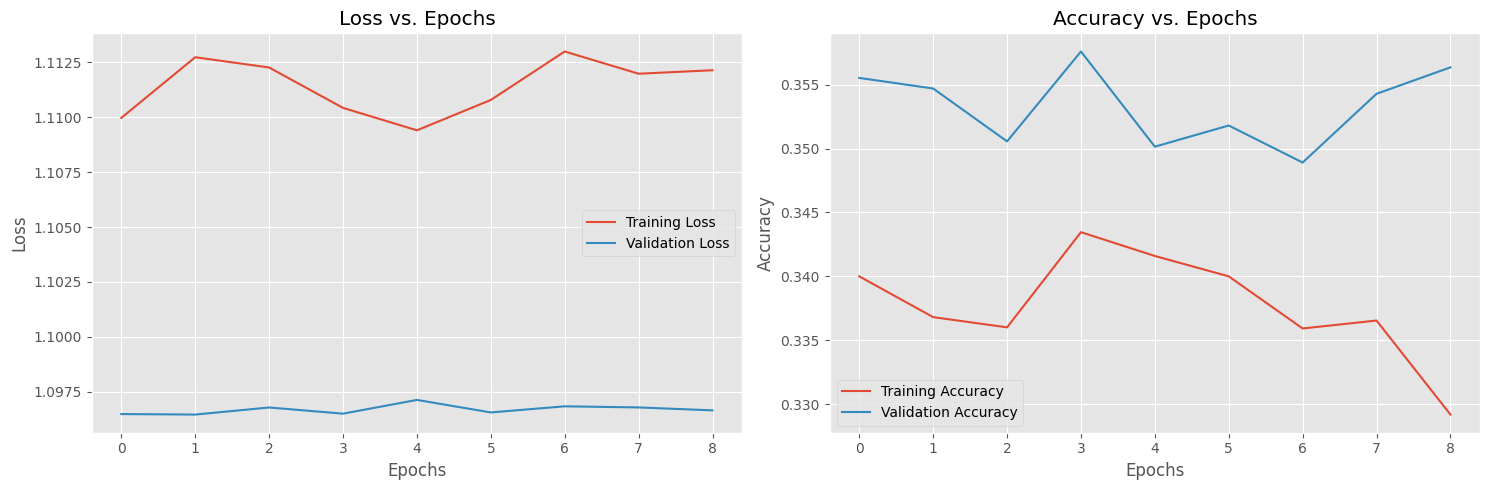

In [78]:
plt.style.use('ggplot')
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
axs[0].plot(history['train_loss'], label='Training Loss')
axs[0].plot(history['val_loss'], label='Validation Loss')
axs[0].set_title('Loss vs. Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Accuracy plot
axs[1].plot(history['train_acc'], label='Training Accuracy')
axs[1].plot(history['val_acc'], label='Validation Accuracy')
axs[1].set_title('Accuracy vs. Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.tight_layout()
plt.show()

## 9. Testing

In [79]:
print("\nEvaluating on Test Set...")
if best_model_wts:
    model.load_state_dict(best_model_wts) # Load best weights
else:
    print("Warning: No best model weights saved. Evaluating with final weights.")

model.eval()
test_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes).to(DEVICE)
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        # Filter out dummy data if any were returned by dataset
        valid_indices = labels != -1
        if not valid_indices.all():
             print(f"Filtering { (~valid_indices).sum() } invalid samples in test batch.")
             inputs = inputs[valid_indices]
             labels = labels[valid_indices]
             if inputs.shape[0] == 0: continue # Skip if batch becomes empty

        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)

        test_accuracy.update(preds, labels)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

final_test_acc = test_accuracy.compute()
print(f"\nFinal Test Accuracy: {final_test_acc.item():.4f}")

# Print classification report (requires labels to be strings or mapped back)
try:
    inv_label_map = {v: k for k, v in label_map.items()}
    all_preds_labels = [inv_label_map[p] for p in all_preds]
    all_true_labels = [inv_label_map[l] for l in all_labels]
    print("\nClassification Report:")
    print(classification_report(all_true_labels, all_preds_labels, target_names=label_map.keys()))
except Exception as e:
    print(f"\nCould not generate classification report: {e}")


Evaluating on Test Set...

Final Test Accuracy: 0.3607

Classification Report:
              precision    recall  f1-score   support

         cat       0.40      0.33      0.36       848
         dog       0.34      0.35      0.35       786
        wild       0.35      0.40      0.38       786

    accuracy                           0.36      2420
   macro avg       0.36      0.36      0.36      2420
weighted avg       0.36      0.36      0.36      2420



## 10. Inference Function

In [80]:
def predict_single_image(image_path, model_path, label_map_path, transform, device):
    """Loads the model and predicts the class of a single image."""
    try:
        # Load label map
        with open(label_map_path, 'r') as f:
            label_map = json.load(f)
        inv_label_map = {v: k for k, v in label_map.items()}
        num_classes_inf = len(label_map)

        # Load image
        image = Image.open(image_path).convert('RGB')
        input_tensor = transform(image).unsqueeze(0).to(device) # Apply transform and add batch dim

        # Load model
        inf_model = Net(num_classes=num_classes_inf).to(device)
        inf_model.load_state_dict(torch.load(model_path, map_location=device))
        inf_model.eval() # Set to evaluation mode

        # Predict
        with torch.no_grad():
            output = inf_model(input_tensor)
            probabilities = torch.softmax(output, dim=1) # Convert logits to probabilities
            confidence, predicted_idx = torch.max(probabilities, 1)
            predicted_label = inv_label_map[predicted_idx.item()]

        return predicted_label, confidence.item()

    except FileNotFoundError:
        return f"Error: File not found at {image_path} or model/map path.", 0.0
    except KeyError as e:
        return f"Error: Label mapping issue during prediction - {e}", 0.0
    except Exception as e:
        return f"An error occurred during prediction: {e}", 0.0

In [81]:
example_image_path = '/content/test.jpg' # Make sure this file exists
if os.path.exists(example_image_path):
    predicted_class, confidence_score = predict_single_image(
        example_image_path,
        MODEL_SAVE_PATH,
        LABEL_MAP_PATH,
        val_test_transform, # Use the non-augmenting transform
        DEVICE
    )
    print(f"\nInference on '{example_image_path}':")
    print(f"Predicted Class: {predicted_class}")
    print(f"Confidence: {confidence_score:.4f}")
else:
    print(f"\nSkipping inference example: Image '{example_image_path}' not found.")


Inference on '/content/test.jpg':
Predicted Class: wild
Confidence: 0.3517
